In [1]:
%pylab inline
from classy import Class
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.special import spherical_jn, sici
from sympy.physics.wigner import wigner_3j

# Parameters
z = 0.57
h = 0.68
R_min = 20
R_max = 160
n_r = 10
LMAX = 4

Populating the interactive namespace from numpy and matplotlib


In [2]:
### Load matter power spectrum (for testing)
print("NEED TO ADD PROPER POWER SPECTRUM!")
cosmo = Class()
cosmo.set({'output':'mPk,mTk,tCl','z_pk':z,'h':h})
cosmo.compute()

k_arr = np.logspace(-4,2,10000)
pk_lin_arr = np.asarray([cosmo.pk_lin(kk*h,z)*h**3. for kk in k_arr])

# Load transfer functions
T_all = cosmo.get_transfer(z,'class')
kTk = T_all['k (h/Mpc)']
Tk = T_all['d_tot']
Tk_arr = interp1d(kTk,Tk)(k_arr)

# Compute interpolator for curvature power spectrum and transfer function
p_zeta = interp1d(k_arr,pk_lin_arr/Tk_arr**2.)
M = interp1d(k_arr,Tk_arr)

NEED TO ADD PROPER POWER SPECTRUM!


In [3]:
# Define arrays
s_arr = np.arange(0,250,0.1)[None,:]
x_arr = np.arange(0,250,0.1)
k_arr = np.arange(0.001,10,0.01)[:,None]

# Define bin-integrated Bessel functions
def integ_bessel(ell,bin1,k):
    r_min = bin1*(R_max-R_min)/n_r+R_min
    r_max = (bin1+1.)*(R_max-R_min)/n_r+R_min
    if ell==0:
        tmp1 = (-k*r_max*np.cos(k*r_max)+np.sin(k*r_max))/k**3. 
        tmp2 = (-k*r_min*np.cos(k*r_min)+np.sin(k*r_min))/k**3.
    elif ell==1:
        tmp1 = -2.*np.cos(k*r_max)/k**3. - r_max*np.sin(k*r_max)/k**2.
        tmp2 = -2.*np.cos(k*r_min)/k**3. - r_min*np.sin(k*r_min)/k**2.
    elif ell==2:
        tmp1 = (r_max*np.cos(k*r_max))/k**2 - (4*np.sin(k*r_max))/k**3 + (3*sici(k*r_max)[0])/k**3
        tmp2 = (r_min*np.cos(k*r_min))/k**2 - (4*np.sin(k*r_min))/k**3 + (3*sici(k*r_min)[0])/k**3
    elif ell==3:
        tmp1 = (7.*np.cos(k*r_max))/k**3 - (15.*np.sin(k*r_max))/(k**4*r_max) + (r_max*np.sin(k*r_max))/k**2
        # avoid zero errors!
        if r_min==0:
            tmp2 = -(8./k**3.)
        else:
            tmp2 = (7.*np.cos(k*r_min))/k**3 - (15.*np.sin(k*r_min))/(k**4*r_min) + (r_min*np.sin(k*r_min))/k**2
    elif ell==4:
        tmp1 = (105.*np.cos(k*r_max))/(2.*k**4*r_max) - (r_max*np.cos(k*r_max))/k**2 + (11*np.sin(k*r_max))/k**3 -(105*np.sin(k*r_max))/(2.*k**5*r_max**2) + (15*sici(k*r_max)[0])/(2.*k**3)
        if r_min==0:
            tmp2 = 0.
        else:
            tmp2 = (105.*np.cos(k*r_min))/(2.*k**4*r_min) - (r_min*np.cos(k*r_min))/k**2 + (11*np.sin(k*r_min))/k**3 -(105*np.sin(k*r_min))/(2.*k**5*r_min**2) + (15*sici(k*r_min)[0])/(2.*k**3)
    elif ell==5:
        tmp1 = ((315*k*r_max - 16*k**3*r_max**3)*np.cos(k*r_max) - (315 - 105*k**2*r_max**2 + k**4*r_max**4)*np.sin(k*r_max))/(k**6*r_max**3)
        if r_min==0:
            tmp2 = -16./k**3.
        else:
            tmp2 = ((315*k*r_min - 16*k**3*r_min**3)*np.cos(k*r_min) - (315 - 105*k**2*r_min**2 + k**4*r_min**4)*np.sin(k*r_min))/(k**6*r_min**3)
    else:
        raise Exception("not implemented yet!")
    return (tmp1-tmp2)/((r_max**3.-r_min**3.)/3.)

In [4]:
# Compute j_l(ks) posibilities
jl_ks = []
print("Computing j_ell(ks)")
for l in range(LMAX+1):
    jl_ks.append(spherical_jn(l,k_arr*s_arr))
    
# Compute j_ell(kr) possibilities
jell_kr = []
print("Computing j_ell(kr)")
for ell in range(LMAX+1):
    print("ell = %d"%ell)
    tmp_jell_kr = []
    for rbin in range(n_r):
        tmp_jell_kr.append(integ_bessel(ell,rbin,k_arr))
    jell_kr.append(tmp_jell_kr)
    
# Compute Mk, P_zeta(k)
Mk_arr = M(k_arr)
Pzeta_arr = p_zeta(k_arr)

Computing j_ell(ks)
Computing j_ell(kr)
ell = 0
ell = 1
ell = 2
ell = 3
ell = 4


In [74]:
### Compute zeta_{-1} and zeta_{-2}
from mcfit import P2xi
kk = np.logspace(-4,1,100000)
zeta_neg1_int = interp1d(*P2xi(kk)(p_zeta(kk)))
zeta_neg2_int = interp1d(*P2xi(kk)(p_zeta(kk)/kk**2.))

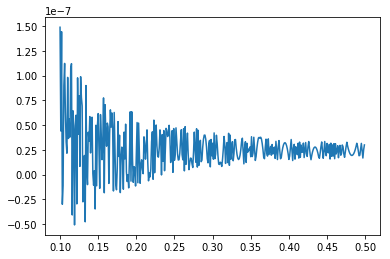

In [75]:
x_arr = np.arange(0.1,0.5,0.001)
plt.plot(x_arr,zeta_neg1_int(x_arr))
#plt.plot(x_arr,zeta_neg2_int(x_arr))

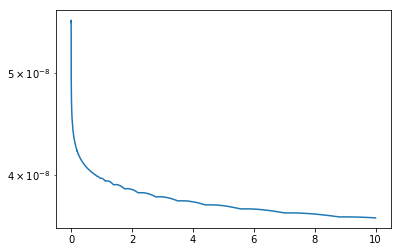

In [59]:
plt.plot(kk,p_zeta(kk)*kk**3.)
plt.yscale('log')

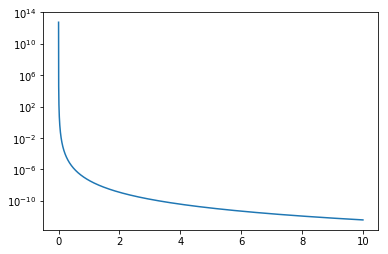

In [55]:
plt.plot(kk,p_zeta(kk)/kk**2);
plt.yscale('log')

#### Compute Q arrays

In [ ]:
def compute_Q3(ell,l,rbin):
    return simps(k_arr**2.*jl_ks[l]*Mk*Pzeta_arr*jell_kr[ell][rbin],k_arr,axis=0)/(2.*np.pi**2.)*(-1.)**l

def compute_Q4(ell,l,rbin):
    return simps(k_arr**2.*jl_ks[l]*Mk*jell_kr[ell][rbin],k_arr,axis=0)/(2.*np.pi**2.)*(-1.)**l

In [ ]:
# Compute all Q integrals
Q3 = []
Q4 = []

for rbin in range(n_r):
    print("On r-bin %d of %d"%(rbin,n_r))
    Q3ii = []
    Q4ii = []
    for ell in range(LMAX+1):
        Q3i = []
        Q4i = []
        for l in range(LMAX+1):
            Q3i.append(compute_Q3(ell,l,rbin))
            Q4i.append(compute_Q4(ell,l,rbin))
        Q3ii.append(Q3i)
        Q4ii.append(Q4ii)
    Q3.append(Q3ii)
    Q4.append(Q4ii)

In [ ]:
plt.plot(Q4[0][2][2])
plt.plot(Q4[1][1][6])